# VIF Critic Training v2 — Diagnostic-First Notebook

This notebook is a **diagnostic-first** training notebook for the VIF Critic model,
extended with **multi-model comparison** across ordinal loss functions.
Every section maps to specific GitHub issues and prints results explicitly.

**Issues Surfaced:**
- **#9** — Uncertainty calibration quality
- **#10** — Class imbalance and neutral-dominated predictions
- **#12** — Overfitting risk with high parameter-to-sample ratio
- **#14** — Embedding quality and truncation risk

**Models Compared:**
- **CORAL** — Consistent Rank Logits (cumulative binary CE)
- **CORN** — Conditional Ordinal Regression Network
- **EMD** — Earth Mover Distance (squared L2 between CDFs)
- **SoftOrdinal** — KL divergence with smoothed ordinal targets

**Scope:** MLP-based multi-model comparison. Diagnostic embedding probe. Metrics + guidance scorecard.

# Config

In [ ]:
CONFIG = {
    # Encoder
    "encoder_model": "nomic-ai/nomic-embed-text-v1.5",
    "trust_remote_code": True,
    "truncate_dim": 256,  # Matryoshka truncation (MTEB 61.04 @ 256d)
    "text_prefix": "classification: ",  # Required task prefix for nomic models
    # Models to compare
    "models_to_train": ["CORAL", "CORAL_IW"],
    # Model — reduced to control overfitting (was hidden=256, dropout=0.2)
    "hidden_dim": 64,
    "dropout": 0.3,
    # Optimizer
    "learning_rate": 0.001,
    "weight_decay": 0.01,
    # Training
    "batch_size": 16,
    "epochs": 100,
    # Early stopping
    "early_stopping_patience": 20,
    "early_stopping_min_delta": 0.001,
    # LR scheduler
    "scheduler_factor": 0.5,
    "scheduler_patience": 10,
    "scheduler_min_lr": 1e-5,
    # State encoder — window=1 to cut state_dim (was 3, ratio=432x)
    "window_size": 1,
    # MC Dropout
    "mc_dropout_samples": 50,
    # Data splits
    "train_ratio": 0.70,
    "val_ratio": 0.15,
    "seed": 2025,
}

print("=" * 50)
print("CONFIGURATION")
print("=" * 50)
for key, value in CONFIG.items():
    print(f"  {key:<30s} {str(value):>15s}")
print("=" * 50)

# Import Libs

In [ ]:
import os
import sys
from functools import partial
from pathlib import Path

# Walk up to find project root (contains src/ and pyproject.toml)
_dir = Path.cwd()
while _dir != _dir.parent:
    if (_dir / "src").is_dir() and (_dir / "pyproject.toml").is_file():
        os.chdir(_dir)
        break
    _dir = _dir.parent
sys.path.insert(0, ".")

import numpy as np
import polars as pl
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity

from src.vif.dataset import (
    load_all_data,
    split_by_persona,
    merge_labels_and_entries,
    VIFDataset,
)
from src.vif.encoders import SBERTEncoder
from src.vif.state_encoder import StateEncoder
from src.vif.critic_ordinal import (
    CriticMLPCORAL,
    coral_loss_multi,
    compute_coral_importance_weights,
    coral_loss_multi_weighted,
    CriticMLPCORN,
    corn_loss_multi,
    CriticMLPEMD,
    emd_loss_multi,
    CriticMLPSoftOrdinal,
    soft_ordinal_loss_multi,
)
from src.vif.eval import (
    evaluate_with_uncertainty,
    format_results_table,
    discretize_predictions,
)
from src.models.judge import SCHWARTZ_VALUE_ORDER

# Reproducibility
np.random.seed(CONFIG["seed"])
torch.manual_seed(CONFIG["seed"])

# Device selection
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Working directory: {os.getcwd()}")
print(f"Device: {device}")
print(f"PyTorch: {torch.__version__}")
print(f"Schwartz dimensions: {len(SCHWARTZ_VALUE_ORDER)}")

# Section 1: Data Quality Audit (Issue #10)

**Issue #10 — Class Imbalance:**: Most Schwartz dimensions are neutral-dominated.
The model may learn to predict `0` for everything and still achieve high accuracy.
This section quantifies the imbalance and flags dimensions that may be unlearnable.

* `labels_df` - judge-assigned alignment scores
* `entries_df` - journal text

In [3]:
labels_df, entries_df = load_all_data()
merged_df = merge_labels_and_entries(labels_df, entries_df)

print(f"Labels shape:  {labels_df.shape}")
print(f"Entries shape: {entries_df.shape}")
print(f"Merged shape:  {merged_df.shape}")
print(f"Unique personas: {merged_df.select('persona_id').n_unique()}")


Labels shape:  (1460, 15)
Entries shape: (1460, 8)
Merged shape:  (1460, 21)
Unique personas: 180


In [4]:
labels_df.head().glimpse()

Rows: 5
Columns: 15
$ persona_id                     <str> '013d8101', '013d8101', '013d8101', '019235dc', '019235dc'
$ t_index                        <i64> 0, 1, 2, 0, 1
$ date                           <str> '2025-12-01', '2025-12-11', '2025-12-20', '2025-01-15', '2025-01-15'
$ alignment_vector         <list[i64]> [0, 0, 0, 0, 0, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 1, 0], [0, -1, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
$ alignment_self_direction       <i64> 0, 0, 0, 0, 0
$ alignment_stimulation          <i64> 0, 0, -1, 0, 0
$ alignment_hedonism             <i64> 0, 0, 0, 0, 0
$ alignment_achievement          <i64> 0, 0, 0, 1, 1
$ alignment_power                <i64> 0, 0, 0, 1, 0
$ alignment_security             <i64> 1, 1, 1, 0, 0
$ alignment_conformity           <i64> 1, 0, 0, 0, 0
$ alignment_tradition            <i64> 0, 0, 0, 0, 0
$ alignment_benevolence          <i64> 0, 1, 0, 0, 1
$ alignment_universalism         <i64> 0, 0,

In [5]:
entries_df.head().glimpse()

Rows: 5
Columns: 8
$ persona_id          <str> '013d8101', '013d8101', '013d8101', '019235dc', '019235dc'
$ persona_name        <str> 'Emma Lindqvist', 'Emma Lindqvist', 'Emma Lindqvist', 'Megan Torres', 'Megan Torres'
$ core_values   <list[str]> ['Security'], ['Security'], ['Security'], ['Achievement', 'Benevolence'], ['Achievement', 'Benevolence']
$ t_index             <i64> 0, 1, 2, 0, 1
$ date                <str> '2025-12-01', '2025-12-11', '2025-12-20', '2025-01-15', '2025-01-15'
$ initial_entry       <str> 'Parent-teacher conferences tomorrow and I keep running through the talking points in my head. Mikkel says I over-prepare but I would rather have every answer ready than stumble in front of someone asking about their child.', 'The school announced budget cuts today and there were some worried faces in the staff room. I felt steady, actually. My position is permanent and I have been here longer than most.', 'Mikkel brought up the idea of moving to Berlin again at dinner. His co

In [6]:
dropped_label_rows = labels_df.height - merged_df.height
if dropped_label_rows > 0:
    print(f"Dropped label rows after merge: {dropped_label_rows}")
    key_options = [
        ["persona_id", "t_index"],
        ["entry_id"],
    ]
    for keys in key_options:
        if all(k in labels_df.columns for k in keys) and all(
            k in merged_df.columns for k in keys
        ):
            labels_keys = labels_df.select(keys).unique()
            merged_keys = merged_df.select(keys).unique()
            dropped_keys = labels_keys.join(merged_keys, on=keys, how="anti")
            print(f"  Missing key rows by {keys}: {dropped_keys.height}")
            if dropped_keys.height > 0:
                print(dropped_keys.head(5))
            break

print(
    f"\nLabel columns: {[c for c in labels_df.columns if c.startswith('alignment_')]}"
)
print(
    f"\nEntry text columns: {[c for c in entries_df.columns if c not in labels_df.columns]}"
)


Label columns: ['alignment_vector', 'alignment_self_direction', 'alignment_stimulation', 'alignment_hedonism', 'alignment_achievement', 'alignment_power', 'alignment_security', 'alignment_conformity', 'alignment_tradition', 'alignment_benevolence', 'alignment_universalism']

Entry text columns: ['persona_name', 'core_values', 'initial_entry', 'nudge_text', 'response_text']


## Class Distribution per Dimension

In [7]:
n_dims = len(SCHWARTZ_VALUE_ORDER)
distribution = np.zeros((n_dims, 3), dtype=int)  # rows=dims, cols=[-1, 0, +1]
class_labels = [-1, 0, 1]

for i, dim in enumerate(SCHWARTZ_VALUE_ORDER):
    col = f"alignment_{dim}"
    series = merged_df.select(col).to_series()
    for j, val in enumerate(class_labels):
        distribution[i, j] = int((series == val).sum())

# Compute imbalance ratios
imbalance_ratios = []
for i in range(n_dims):
    row = distribution[i]
    ratio = float("inf") if (row == 0).any() else row.max() / row.min()
    imbalance_ratios.append(ratio)

# Print table
print(f"{'Dimension':<20s} {'-1':>6s} {'0':>6s} {'+1':>6s} {'Ratio':>8s} {'Flag':>8s}")
print("-" * 55)
for i, dim in enumerate(SCHWARTZ_VALUE_ORDER):
    flag = ">10x" if imbalance_ratios[i] > 10 else ""
    print(
        f"{dim:<20s} {distribution[i, 0]:>6d} {distribution[i, 1]:>6d} {distribution[i, 2]:>6d} {imbalance_ratios[i]:>8.1f} {flag:>8s}"
    )

neutral_pct = distribution[:, 1].sum() / distribution.sum() * 100
print(f"\nOverall neutral %: {neutral_pct:.1f}%")

Dimension                -1      0     +1    Ratio     Flag
-------------------------------------------------------
self_direction          204    859    397      4.2         
stimulation              51   1282    127     25.1     >10x
hedonism                117   1185    158     10.1     >10x
achievement              81    988    391     12.2     >10x
power                   121   1187    152      9.8         
security                136   1100    224      8.1         
conformity              126   1017    317      8.1         
tradition                58   1148    254     19.8     >10x
benevolence             120    912    428      7.6         
universalism             56   1246    158     22.2     >10x

Overall neutral %: 74.8%


Heatmap:

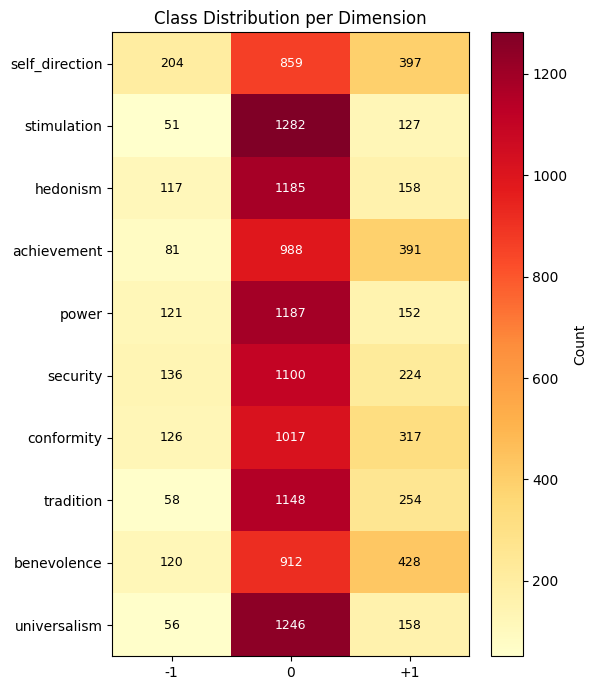

In [8]:
fig, ax = plt.subplots(figsize=(6, 7))
im = ax.imshow(distribution, cmap="YlOrRd", aspect="auto")
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["-1", "0", "+1"])
ax.set_yticks(range(n_dims))
ax.set_yticklabels(SCHWARTZ_VALUE_ORDER)
ax.set_title("Class Distribution per Dimension")
for i in range(n_dims):
    for j in range(3):
        color = "white" if distribution[i, j] > distribution.max() * 0.6 else "black"
        ax.text(
            j,
            i,
            str(distribution[i, j]),
            ha="center",
            va="center",
            fontsize=9,
            color=color,
        )
plt.colorbar(im, ax=ax, label="Count")
plt.tight_layout()
plt.show()

Sparsity flags: Checking all dimensions where any class < 10 samples

In [9]:
MIN_SAMPLES = 10

print(f"{'Dimension':<20s} {'Min class':>10s} {'Min count':>10s} {'Status':>12s}")
print("-" * 55)
unlearnable = []
for i, dim in enumerate(SCHWARTZ_VALUE_ORDER):
    min_idx = distribution[i].argmin()
    min_count = distribution[i, min_idx]
    min_class = class_labels[min_idx]
    status = "UNLEARNABLE" if min_count < MIN_SAMPLES else "OK"
    if min_count < MIN_SAMPLES:
        unlearnable.append(dim)
    print(f"{dim:<20s} {min_class:>10d} {min_count:>10d} {status:>12s}")

print(
    f"\nUnlearnable dims (any class < {MIN_SAMPLES} samples): {unlearnable if unlearnable else 'None'}"
)

Dimension             Min class  Min count       Status
-------------------------------------------------------
self_direction               -1        204           OK
stimulation                  -1         51           OK
hedonism                     -1        117           OK
achievement                  -1         81           OK
power                        -1        121           OK
security                     -1        136           OK
conformity                   -1        126           OK
tradition                    -1         58           OK
benevolence                  -1        120           OK
universalism                 -1         56           OK

Unlearnable dims (any class < 10 samples): None


# Section 2: Embedding Quality Probe (Issue #14)


**Issue #14 — Embedding Quality:** Are SBERT embeddings discriminative enough for value alignment? Does truncation lose information from long entries?

This section probes the encoder without retraining.

In [10]:
text_encoder = SBERTEncoder(
    CONFIG["encoder_model"],
    trust_remote_code=CONFIG["trust_remote_code"],
    truncate_dim=CONFIG["truncate_dim"],
    text_prefix=CONFIG["text_prefix"],
)
state_encoder = StateEncoder(
    text_encoder,
    window_size=CONFIG["window_size"],
)

print(f"Encoder: {text_encoder.model_name}")
print(f"Embedding dim: {text_encoder.embedding_dim}")
print(f"State dim: {state_encoder.state_dim}")

<All keys matched successfully>


Encoder: nomic-ai/nomic-embed-text-v1.5
Embedding dim: 256
State dim: 266


In [11]:
# Sample one random entry
rng = np.random.default_rng(CONFIG["seed"])
sample_idx = rng.integers(0, len(merged_df))
sample = merged_df.row(sample_idx, named=True)

print(f"\n{'=' * 60}")
print(f"RANDOM ENTRY VERIFICATION (row {sample_idx})")
print(f"{'=' * 60}")
print(f"persona_id:    {sample['persona_id']}")
print(f"persona_name:  {sample.get('persona_name', 'N/A')}")
print(f"core_values:   {sample.get('core_values', 'N/A')}")
print(f"date:          {sample['date']}")
print(f"t_index:       {sample['t_index']}")

print(f"\n--- initial_entry (first 200 chars) ---")
print(f"{(sample['initial_entry'] or '')[:200]}")
print(f"\n--- nudge_text (first 200 chars) ---")
print(f"{(sample['nudge_text'] or '')[:200]}")
print(f"\n--- response_text (first 200 chars) ---")
print(f"{(sample['response_text'] or '')[:200]}")


RANDOM ENTRY VERIFICATION (row 653)
persona_id:    70b51a5b
persona_name:  Meena Subramanian
core_values:   ['Power']
date:          2025-10-20
t_index:       6

--- initial_entry (first 200 chars) ---
Family WhatsApp group. Vikram posted photos of houses he and Priya are looking at in OMR — those new gated community flats near the IT corridor. Everyone started commenting, congratulating, sending em

--- nudge_text (first 200 chars) ---
What did the deleted messages say?

--- response_text (first 200 chars) ---
The first one asked why I'm always the last to know. The second one said something about respect. I deleted both because I knew Priya would read them too and it would become a whole thing.


Max context length: 8192 tokens

Token count statistics:
  Min:    18
  Mean:   200.8
  Median: 191.5
  P90:    342
  P95:    390
  Max:    709

Truncated entries: 0/1460 (0.0%)


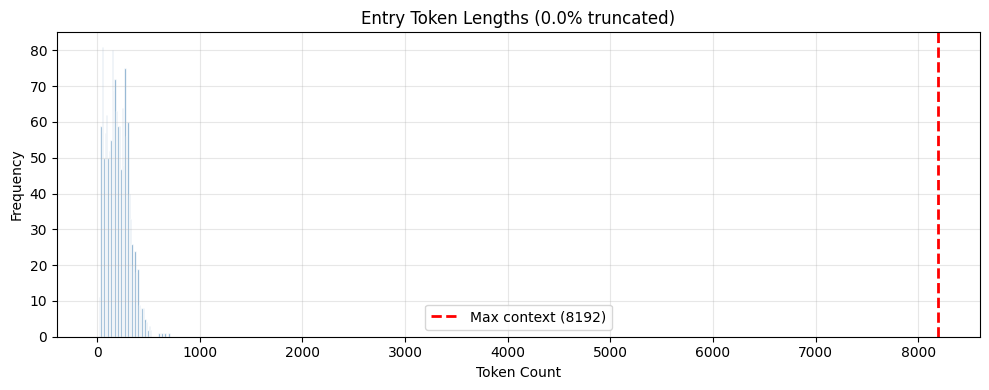

In [12]:
# Cell 2c — Entry length / truncation risk
tokenizer = text_encoder._model.tokenizer
max_seq_length = text_encoder._model.max_seq_length

all_texts = []
for row in merged_df.iter_rows(named=True):
    text = state_encoder.concatenate_entry_text(
        row["initial_entry"], row["nudge_text"], row["response_text"]
    )
    all_texts.append(text)

token_counts = []
for text in all_texts:
    tokens = tokenizer.encode(text, add_special_tokens=True)
    token_counts.append(len(tokens))

token_counts = np.array(token_counts)
n_truncated = (token_counts > max_seq_length).sum()
pct_truncated = n_truncated / len(token_counts) * 100

print(f"Max context length: {max_seq_length} tokens")
print(f"\nToken count statistics:")
print(f"  Min:    {token_counts.min()}")
print(f"  Mean:   {token_counts.mean():.1f}")
print(f"  Median: {np.median(token_counts):.1f}")
print(f"  P90:    {np.percentile(token_counts, 90):.0f}")
print(f"  P95:    {np.percentile(token_counts, 95):.0f}")
print(f"  Max:    {token_counts.max()}")
print(f"\nTruncated entries: {n_truncated}/{len(token_counts)} ({pct_truncated:.1f}%)")

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(token_counts, bins=50, color="steelblue", edgecolor="white", alpha=0.8)
ax.axvline(
    max_seq_length,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Max context ({max_seq_length})",
)
ax.set_xlabel("Token Count")
ax.set_ylabel("Frequency")
ax.set_title(f"Entry Token Lengths ({pct_truncated:.1f}% truncated)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Section 3: Model & Training (Issue #12)


**Issue #12 — Overfitting Risk:** the model has a very high parameter-to-sample ratio. This section quantifies the risk and monitors the training/validation gap.

In [ ]:
MODEL_CONFIGS = {
    "CORAL": {
        "class": CriticMLPCORAL,
        "loss_fn": coral_loss_multi,
        "is_ordinal": True,
    },
    # CORAL_IW is added after the train/val/test split (cell 3b) to avoid
    # leaking holdout label distribution into the importance weights.
    "CORN": {
        "class": CriticMLPCORN,
        "loss_fn": corn_loss_multi,
        "is_ordinal": True,
    },
    "EMD": {
        "class": CriticMLPEMD,
        "loss_fn": emd_loss_multi,
        "is_ordinal": True,
    },
    "SoftOrdinal": {
        "class": CriticMLPSoftOrdinal,
        "loss_fn": soft_ordinal_loss_multi,
        "is_ordinal": True,
    },
}

In [ ]:
# Filter to active models (preliminary — rebuilt after split once CORAL_IW is added)
active_models = {
    k: dict(v) for k, v in MODEL_CONFIGS.items() if k in CONFIG["models_to_train"]
}

# Print available models (CORAL_IW will be added and printed after the split)
print(f"MODEL_CONFIGS defined: {list(MODEL_CONFIGS.keys())}")
print(f"models_to_train: {CONFIG['models_to_train']}")
print(f"Active now (pre-split): {list(active_models.keys())}")
print("(CORAL_IW weights computed from train split in next cell)")

In [ ]:
# Cell 3b — Create datasets and dataloaders
print("Creating datasets (caching embeddings)...")
train_df, val_df, test_df = split_by_persona(
    labels_df,
    entries_df,
    train_ratio=CONFIG["train_ratio"],
    val_ratio=CONFIG["val_ratio"],
    seed=CONFIG["seed"],
)

train_dataset = VIFDataset(train_df, state_encoder, cache_embeddings=True)
val_dataset = VIFDataset(val_df, state_encoder, cache_embeddings=True)
test_dataset = VIFDataset(test_df, state_encoder, cache_embeddings=True)

train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG["batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG["batch_size"], shuffle=False)

n_train = len(train_dataset)
n_val = len(val_dataset)
n_test = len(test_dataset)

print(f"\nSplit sizes:")
print(
    f"  Train: {n_train} samples ({train_df.select('persona_id').n_unique()} personas) -> {len(train_loader)} batches"
)
print(
    f"  Val:   {n_val} samples ({val_df.select('persona_id').n_unique()} personas) -> {len(val_loader)} batches"
)
print(
    f"  Test:  {n_test} samples ({test_df.select('persona_id').n_unique()} personas) -> {len(test_loader)} batches"
)

# --- CORAL_IW: compute importance weights from TRAIN split only ---
# This avoids leaking holdout label distribution into the loss function.
train_distribution = np.zeros((n_dims, 3), dtype=int)
for i, dim in enumerate(SCHWARTZ_VALUE_ORDER):
    col = f"alignment_{dim}"
    series = train_df.select(col).to_series()
    for j, val in enumerate(class_labels):
        train_distribution[i, j] = int((series == val).sum())

coral_iw = compute_coral_importance_weights(train_distribution, method="inverse_freq")
coral_iw_tensor = coral_iw.to(device)

print("\nCORAL importance weights (from train split only):")
for i, dim in enumerate(SCHWARTZ_VALUE_ORDER):
    print(f"  {dim:<20s}  thresh0={coral_iw[i, 0]:.3f}  thresh1={coral_iw[i, 1]:.3f}")

MODEL_CONFIGS["CORAL_IW"] = {
    "class": CriticMLPCORAL,
    "loss_fn": partial(coral_loss_multi_weighted, importance_weights=coral_iw_tensor),
    "is_ordinal": True,
}

# Rebuild active_models now that CORAL_IW has been added to MODEL_CONFIGS
active_models = {
    k: dict(v) for k, v in MODEL_CONFIGS.items() if k in CONFIG["models_to_train"]
}

if not active_models:
    raise ValueError(
        f"No valid models in models_to_train={CONFIG['models_to_train']}. "
        f"Valid names: {list(MODEL_CONFIGS.keys())}"
    )

# Print active model summary
print(f"\n{'Model':<15s} {'Parameters':>12s} {'Output logits':>15s} {'Loss':>25s}")
print("-" * 70)
n_params = 0
for name, cfg in active_models.items():
    m = cfg["class"](
        input_dim=state_encoder.state_dim,
        hidden_dim=CONFIG["hidden_dim"],
        dropout=CONFIG["dropout"],
    )
    param_count = sum(param.numel() for param in m.parameters())
    n_params = max(n_params, param_count)
    n_out = m.fc_out.out_features
    loss_name = (
        cfg["loss_fn"].__class__.__name__
        if isinstance(cfg["loss_fn"], nn.Module)
        else getattr(cfg["loss_fn"], "__name__", getattr(cfg["loss_fn"], "func", cfg["loss_fn"]).__name__)
    )
    print(f"{name:<15s} {param_count:>12,} {n_out:>15d} {loss_name:>25s}")
print("-" * 70)
print(f"\nMax parameters (for overfitting check): {n_params:,}")

In [16]:
# Cell 3c — Overfitting risk check
param_sample_ratio = n_params / n_train
print(f"Parameters:       {n_params:,}")
print(f"Training samples: {n_train}")
print(f"Param/sample ratio: {param_sample_ratio:.1f}x")
print()
if param_sample_ratio > 100:
    print("SEVERE overfitting risk (>100x). Model will likely memorize training data.")
elif param_sample_ratio > 10:
    print("HIGH overfitting risk (>10x). Strong regularization essential.")
elif param_sample_ratio > 1:
    print("MODERATE overfitting risk (>1x). Monitor train/val gap carefully.")
else:
    print("Low overfitting risk (<1x).")

Parameters:       55,070
Training samples: 1020
Param/sample ratio: 54.0x

HIGH overfitting risk (>10x). Strong regularization essential.


In [17]:
# Cell 3d — Multi-model training loop


def train_model(name, model_cfg, train_loader, val_loader, config, device):
    """Train a single model and return its best state + history.

    Each model uses its own loss for early stopping — losses are on different
    scales (CORAL ~2.0, EMD ~0.2) so cross-model loss comparison
    is not meaningful.
    """
    # Per-model seed for reproducibility
    torch.manual_seed(config["seed"])
    np.random.seed(config["seed"])

    model = model_cfg["class"](
        input_dim=state_encoder.state_dim,
        hidden_dim=config["hidden_dim"],
        dropout=config["dropout"],
    )
    model.to(device)

    loss_fn = model_cfg["loss_fn"]

    optimizer = AdamW(
        model.parameters(),
        lr=config["learning_rate"],
        weight_decay=config["weight_decay"],
    )
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=config["scheduler_factor"],
        patience=config["scheduler_patience"],
        min_lr=config["scheduler_min_lr"],
    )

    history = {"train_loss": [], "val_loss": [], "lr": []}
    best_val_loss = float("inf")
    best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    best_epoch = 0
    patience_counter = 0

    for epoch in range(config["epochs"]):
        # Train
        model.train()
        train_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            output = model(batch_x)
            loss = loss_fn(output, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Validate (using same loss for consistent early stopping)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                output = model(batch_x)
                val_loss += loss_fn(output, batch_y).item()
        val_loss /= len(val_loader)

        if not np.isfinite(val_loss):
            print(f"  Epoch {epoch + 1:3d}: non-finite val_loss, stopping")
            break

        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]["lr"]

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["lr"].append(current_lr)

        if val_loss < best_val_loss - config["early_stopping_min_delta"]:
            best_val_loss = val_loss
            best_epoch = epoch
            best_model_state = {
                k: v.cpu().clone() for k, v in model.state_dict().items()
            }
            patience_counter = 0
            if (epoch + 1) <= 3 or (epoch + 1) % 10 == 0:
                print(
                    f"  Epoch {epoch + 1:3d}: train={train_loss:.4f}, "
                    f"val={val_loss:.4f}, lr={current_lr:.6f} [BEST]"
                )
        else:
            patience_counter += 1
            if (epoch + 1) % 10 == 0:
                print(
                    f"  Epoch {epoch + 1:3d}: train={train_loss:.4f}, "
                    f"val={val_loss:.4f}, lr={current_lr:.6f}"
                )

        if patience_counter >= config["early_stopping_patience"]:
            print(f"  Early stopping at epoch {epoch + 1}")
            break

    # Restore best model
    model.load_state_dict(best_model_state)
    model.to(device)

    return {
        "model": model,
        "history": history,
        "best_epoch": best_epoch,
        "best_val_loss": best_val_loss,
    }


# Train all active models
trained_models = {}
skipped_models = {}
for name, cfg in active_models.items():
    print(f"\n{'=' * 70}")
    print(f"Training {name}")
    print(f"{'=' * 70}")
    result = train_model(name, cfg, train_loader, val_loader, CONFIG, device)
    n_epochs = len(result["history"]["train_loss"])
    if n_epochs == 0:
        skipped_models[name] = result
        print("  No valid epochs completed; excluding model from evaluation.")
        continue

    trained_models[name] = result
    print(
        f"  Best val loss: {result['best_val_loss']:.4f} "
        f"at epoch {result['best_epoch'] + 1}/{n_epochs}"
    )

if not trained_models:
    raise RuntimeError("No models completed any valid epochs. Check training logs.")

print(f"\n{'=' * 70}")
print(
    f"Training complete: {len(trained_models)} successful, "
    f"{len(skipped_models)} skipped"
)
print(f"{'=' * 70}")


Training CORAL
  Epoch   1: train=0.8071, val=0.6503, lr=0.001000 [BEST]
  Epoch   2: train=0.6651, val=0.5432, lr=0.001000 [BEST]
  Epoch   3: train=0.5886, val=0.5040, lr=0.001000 [BEST]
  Epoch  10: train=0.4308, val=0.4764, lr=0.001000
  Epoch  20: train=0.2894, val=0.5192, lr=0.000500
  Early stopping at epoch 28
  Best val loss: 0.4654 at epoch 8/28

Training CORN
  Epoch   1: train=0.4070, val=0.3277, lr=0.001000 [BEST]
  Epoch   2: train=0.3307, val=0.2703, lr=0.001000 [BEST]
  Epoch   3: train=0.2885, val=0.2498, lr=0.001000 [BEST]
  Epoch  10: train=0.2121, val=0.2334, lr=0.001000
  Epoch  20: train=0.1422, val=0.2593, lr=0.000500
  Early stopping at epoch 28
  Best val loss: 0.2311 at epoch 8/28

Training EMD
  Epoch   1: train=0.2178, val=0.1656, lr=0.001000 [BEST]
  Epoch   2: train=0.1774, val=0.1450, lr=0.001000 [BEST]
  Epoch   3: train=0.1630, val=0.1404, lr=0.001000 [BEST]
  Epoch  10: train=0.1245, val=0.1416, lr=0.001000
  Epoch  20: train=0.0854, val=0.1441, lr=0.

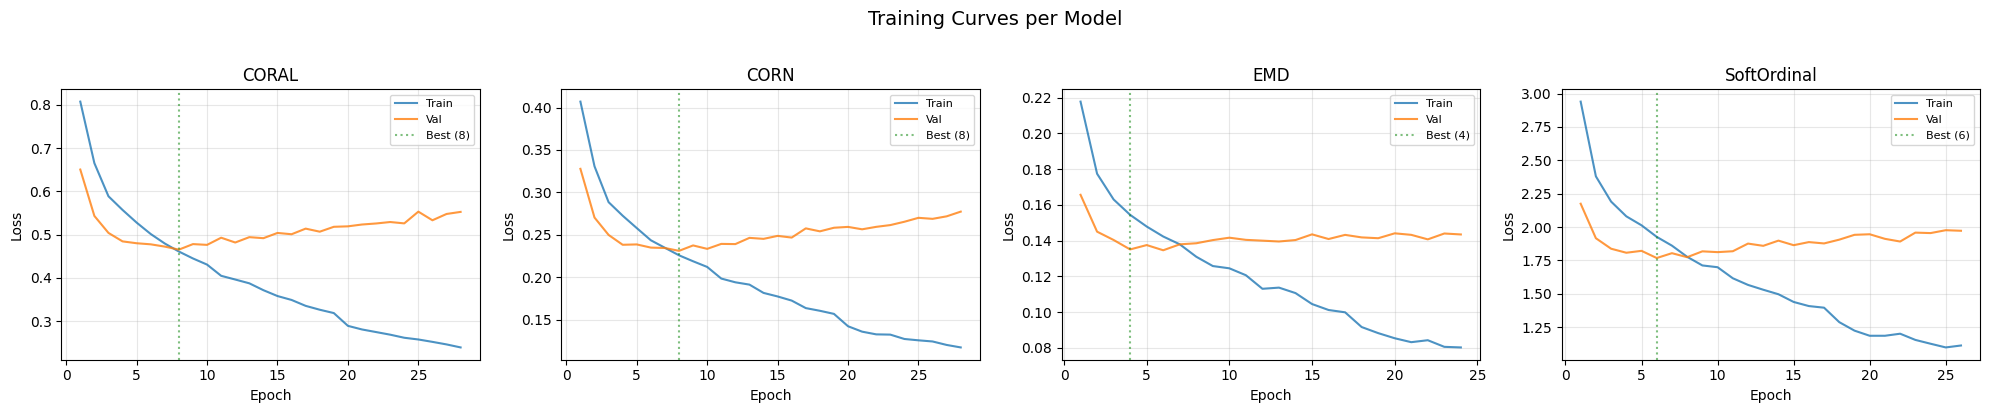


Model             Best epoch   Train loss     Val loss        Gap
-----------------------------------------------------------------
CORAL               8/28          0.4610       0.4654    +0.0044
CORN                8/28          0.2258       0.2311    +0.0053
EMD                 4/24          0.1544       0.1351    -0.0193
SoftOrdinal         6/26          1.9267       1.7682    -0.1585


In [18]:
# Cell 3e — Training curves (one subplot per model)
n_models = len(trained_models)
if n_models == 0:
    print("No models trained. Check training loop logs above.")
else:
    fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 4), squeeze=False)
    axes = axes.flatten()

    for idx, (name, result) in enumerate(trained_models.items()):
        ax = axes[idx]
        history = result["history"]
        best_ep = result["best_epoch"]
        epochs_range = range(1, len(history["train_loss"]) + 1)

        ax.plot(epochs_range, history["train_loss"], label="Train", alpha=0.8)
        ax.plot(epochs_range, history["val_loss"], label="Val", alpha=0.8)
        if len(history["train_loss"]) > 0:
            ax.axvline(
                best_ep + 1,
                color="green",
                linestyle=":",
                alpha=0.5,
                label=f"Best ({best_ep + 1})",
            )
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_title(f"{name}")
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    plt.suptitle("Training Curves per Model", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    # Summary table
    print(
        f"\n{'Model':<15s} {'Best epoch':>12s} {'Train loss':>12s} {'Val loss':>12s} {'Gap':>10s}"
    )
    print("-" * 65)
    for name, result in trained_models.items():
        h = result["history"]
        be = result["best_epoch"]
        n_ep = len(h["train_loss"])
        if n_ep == 0:
            print(f"{name:<15s} {'N/A':>12s} {'N/A':>12s} {'N/A':>12s} {'N/A':>10s}")
            continue
        tl = h["train_loss"][be]
        vl = h["val_loss"][be]
        gap = vl - tl
        print(
            f"{name:<15s} {be + 1:>5d}/{n_ep:<5d} {tl:>12.4f} {vl:>12.4f} {gap:>+10.4f}"
        )

# Section 4: Evaluation Dashboard (Issues #10, #11)


**Issue #10 — Class Imbalance:** Does the model predict only neutrals?

This section provides confusion matrices and prediction distributions to diagnose class imbalance and hedging behavior.

In [19]:
# Cell 4a — Evaluate all models with MC Dropout uncertainty
all_results = {}
for name, result in trained_models.items():
    model = result["model"]
    print(f"\n{'=' * 70}")
    print(f"Evaluating {name} with MC Dropout uncertainty...")
    print(f"{'=' * 70}")
    eval_result = evaluate_with_uncertainty(
        model,
        test_loader,
        n_mc_samples=CONFIG["mc_dropout_samples"],
        device=device,
        include_ordinal_metrics=True,
    )
    all_results[name] = eval_result
    print(f"\n{format_results_table(eval_result)}")

if not all_results:
    raise RuntimeError("No models were evaluated successfully.")


Evaluating CORAL with MC Dropout uncertainty...

Dimension                   MAE   Spearman   Accuracy        QWK
----------------------------------------------------------------
self_direction           0.4010      0.435     64.29%      0.390
stimulation              0.0908      0.526     91.43%      0.429
hedonism                 0.1316      0.481     87.14%      0.279
achievement              0.1785      0.351     87.14%      0.469
power                    0.0648     -0.059     94.76%      0.015
security                 0.3317      0.195     72.86%      0.090
conformity               0.2735      0.560     73.33%      0.452
tradition                0.1403      0.591     86.67%      0.495
benevolence              0.2063      0.587     82.38%      0.554
universalism             0.2215      0.306     83.81%      0.237
----------------------------------------------------------------
MEAN                     0.2040      0.397     82.38%      0.341

Calibration:
  Error-uncertainty correl

Model Comparison:
shape: (4, 6)
┌─────────────┬────────┬──────────┬────────┬──────────┬─────────────┐
│ Model       ┆ MAE    ┆ Accuracy ┆ QWK    ┆ Spearman ┆ Calibration │
│ ---         ┆ ---    ┆ ---      ┆ ---    ┆ ---      ┆ ---         │
│ str         ┆ f64    ┆ f64      ┆ f64    ┆ f64      ┆ f64         │
╞═════════════╪════════╪══════════╪════════╪══════════╪═════════════╡
│ CORAL       ┆ 0.204  ┆ 0.8238   ┆ 0.3409 ┆ 0.3972   ┆ 0.8051      │
│ CORN        ┆ 0.2032 ┆ 0.8276   ┆ 0.3441 ┆ 0.3588   ┆ 0.7849      │
│ EMD         ┆ 0.2    ┆ 0.8205   ┆ 0.3647 ┆ 0.3896   ┆ 0.8022      │
│ SoftOrdinal ┆ 0.2008 ┆ 0.8262   ┆ 0.3537 ┆ 0.387    ┆ 0.8107      │
└─────────────┴────────┴──────────┴────────┴──────────┴─────────────┘


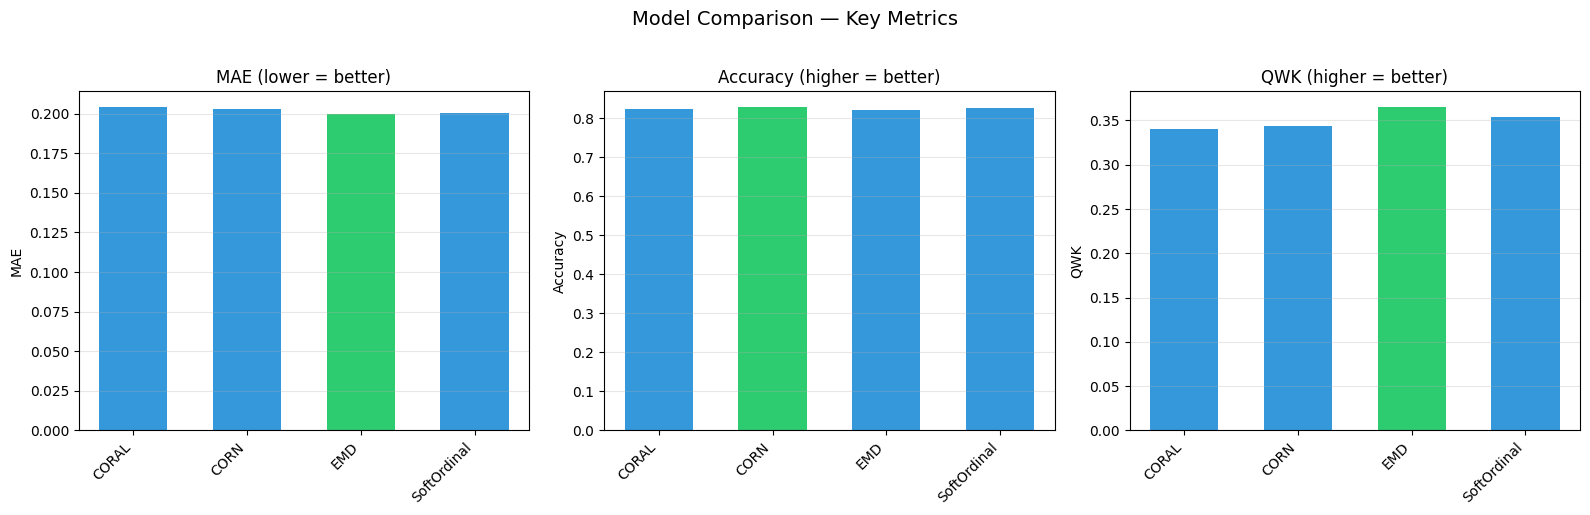

In [20]:
# Cell 4b — Model comparison table and grouped bar chart

# Build comparison DataFrame
rows = []
for name, res in all_results.items():
    rows.append(
        {
            "Model": name,
            "MAE": round(res["mae_mean"], 4),
            "Accuracy": round(res["accuracy_mean"], 4),
            "QWK": round(res["qwk_mean"], 4),
            "Spearman": round(res["spearman_mean"], 4),
            "Calibration": round(
                res["calibration"]["error_uncertainty_correlation"], 4
            ),
        }
    )

if not rows:
    raise RuntimeError("No evaluated models available for comparison.")

comparison_df = pl.DataFrame(rows)
print("Model Comparison:")
print(comparison_df)

# Grouped bar chart for 3 key metrics
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
model_names = comparison_df["Model"].to_list()
x = np.arange(len(model_names))
width = 0.6

# MAE (lower is better)
mae_vals = comparison_df["MAE"].to_list()
best_mae = min(mae_vals)
colors = ["#2ecc71" if v == best_mae else "#3498db" for v in mae_vals]
axes[0].bar(x, mae_vals, width, color=colors)
axes[0].set_xticks(x)
axes[0].set_xticklabels(model_names, rotation=45, ha="right")
axes[0].set_ylabel("MAE")
axes[0].set_title("MAE (lower = better)")
axes[0].grid(True, alpha=0.3, axis="y")

# Accuracy (higher is better)
acc_vals = comparison_df["Accuracy"].to_list()
best_acc = max(acc_vals)
colors = ["#2ecc71" if v == best_acc else "#3498db" for v in acc_vals]
axes[1].bar(x, acc_vals, width, color=colors)
axes[1].set_xticks(x)
axes[1].set_xticklabels(model_names, rotation=45, ha="right")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy (higher = better)")
axes[1].grid(True, alpha=0.3, axis="y")

# QWK (higher is better)
qwk_vals = comparison_df["QWK"].to_list()
best_qwk = max(qwk_vals)
colors = ["#2ecc71" if v == best_qwk else "#3498db" for v in qwk_vals]
axes[2].bar(x, qwk_vals, width, color=colors)
axes[2].set_xticks(x)
axes[2].set_xticklabels(model_names, rotation=45, ha="right")
axes[2].set_ylabel("QWK")
axes[2].set_title("QWK (higher = better)")
axes[2].grid(True, alpha=0.3, axis="y")

plt.suptitle("Model Comparison — Key Metrics", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

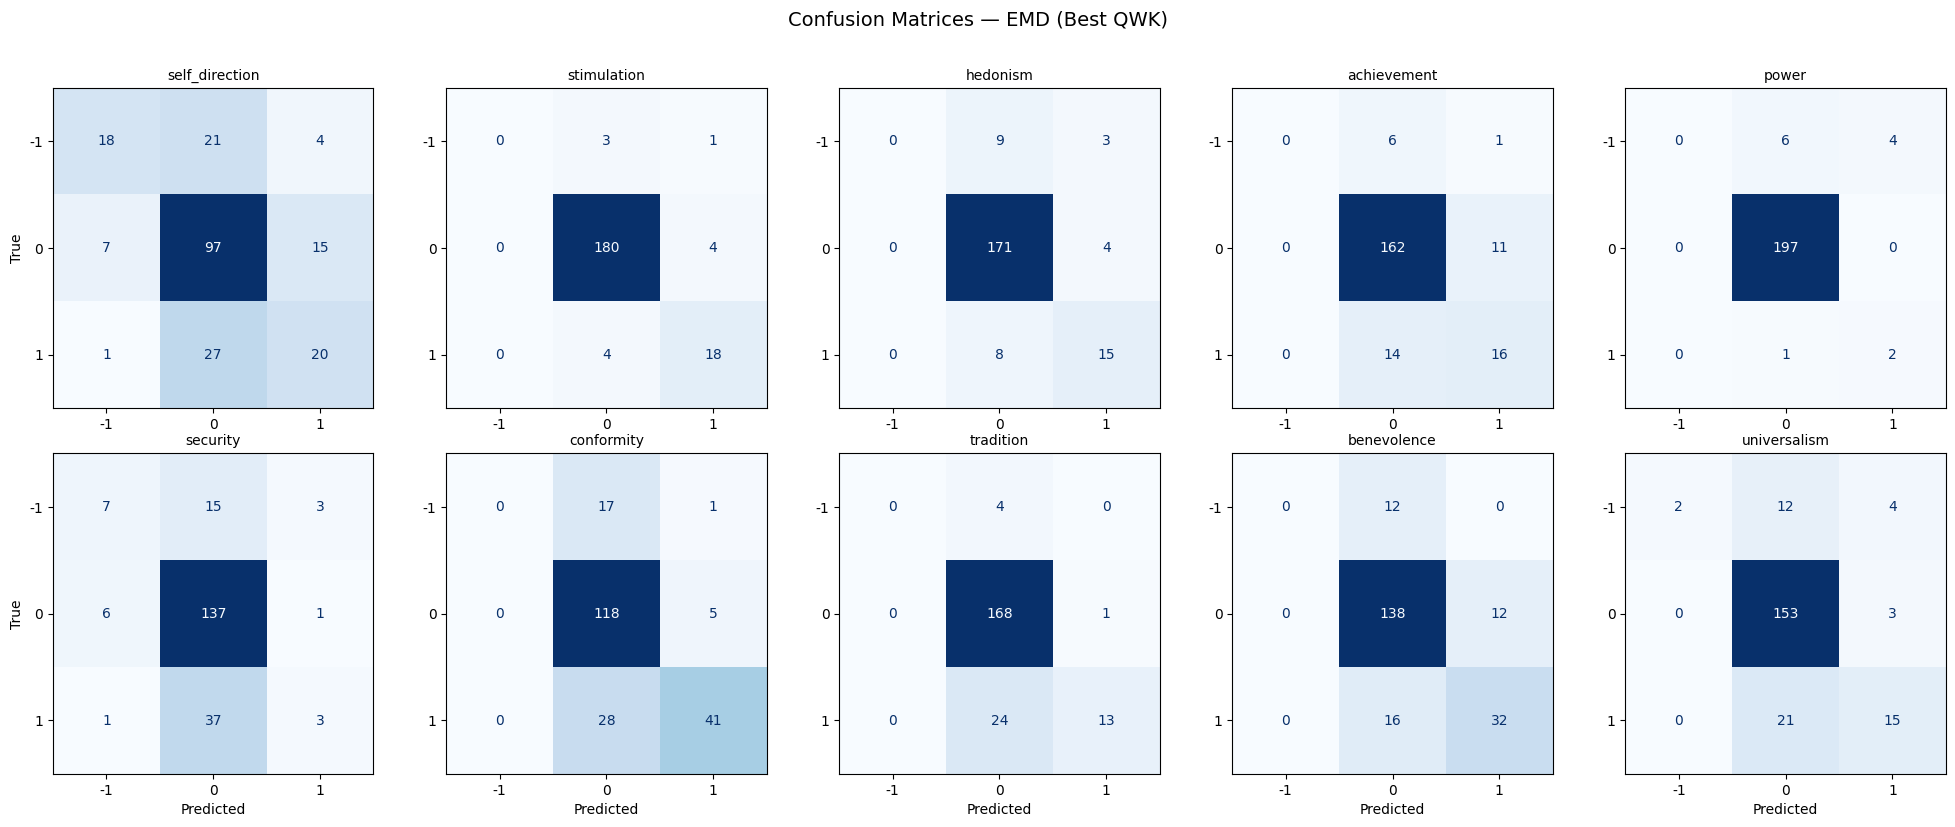


Per-Class Recall Across Models (aggregated over 10 dimensions)

Model            Recall -1   Recall 0  Recall +1   Mean minority
--------------------------------------------------------------
CORAL                 4.9%      96.4%      49.6%           27.3%
CORN                  5.7%      97.2%      49.5%           27.6%
EMD                   8.1%      95.1%      51.9%           30.0%
SoftOrdinal           6.7%      96.0%      51.5%           29.1%


In [21]:
# Cell 4c — Confusion matrices for best model + per-class recall

# Find best model by QWK
best_model_name = max(all_results, key=lambda n: all_results[n]["qwk_mean"])

# Plot confusion matrices for best model (2x5 grid)
res = all_results[best_model_name]
pred_cls = discretize_predictions(res["predictions"])
target_cls = discretize_predictions(res["targets"])

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes_flat = axes.flatten()
for i, dim in enumerate(SCHWARTZ_VALUE_ORDER):
    cm = confusion_matrix(target_cls[:, i], pred_cls[:, i], labels=[-1, 0, 1])
    disp = ConfusionMatrixDisplay(cm, display_labels=[-1, 0, 1])
    disp.plot(ax=axes_flat[i], cmap="Blues", colorbar=False)
    axes_flat[i].set_title(dim, fontsize=10)
    axes_flat[i].set_xlabel("Predicted" if i >= 5 else "")
    axes_flat[i].set_ylabel("True" if i % 5 == 0 else "")
plt.suptitle(f"Confusion Matrices — {best_model_name} (Best QWK)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Per-class recall table across all models
print(f"\n{'=' * 70}")
print("Per-Class Recall Across Models (aggregated over 10 dimensions)")
print(f"{'=' * 70}")
print(
    f"\n{'Model':<15s} {'Recall -1':>10s} {'Recall 0':>10s} "
    f"{'Recall +1':>10s} {'Mean minority':>15s}"
)
print("-" * 62)

all_recall_data = {}
for model_name, res in all_results.items():
    pred_cls = discretize_predictions(res["predictions"])
    target_cls = discretize_predictions(res["targets"])

    recall_minus1 = []
    recall_zero = []
    recall_plus1 = []

    for i, dim in enumerate(SCHWARTZ_VALUE_ORDER):
        cm = confusion_matrix(target_cls[:, i], pred_cls[:, i], labels=[-1, 0, 1])
        for c, recall_list in enumerate([recall_minus1, recall_zero, recall_plus1]):
            row_sum = cm[c].sum()
            recall = cm[c, c] / row_sum if row_sum > 0 else float("nan")
            recall_list.append(recall)

    mean_r_neg = np.nanmean(recall_minus1)
    mean_r_zero = np.nanmean(recall_zero)
    mean_r_pos = np.nanmean(recall_plus1)
    mean_minority = np.nanmean(recall_minus1 + recall_plus1)

    all_recall_data[model_name] = {
        "recall_minus1": mean_r_neg,
        "recall_zero": mean_r_zero,
        "recall_plus1": mean_r_pos,
        "mean_minority": mean_minority,
    }

    print(
        f"{model_name:<15s} {mean_r_neg:>10.1%} {mean_r_zero:>10.1%} "
        f"{mean_r_pos:>10.1%} {mean_minority:>15.1%}"
    )

In [22]:
# Cell 4d — Hedging comparison: % predictions in [-0.3, 0.3] per model

print(f"{'=' * (20 + 13 * len(all_results))}")
print("Hedging Comparison — % predictions in [-0.3, 0.3]")
print(f"{'=' * (20 + 13 * len(all_results))}")

print(f"\n{'Dimension':<20s}", end="")
for name in all_results:
    print(f" {name:>12s}", end="")
print()
print("-" * (20 + 13 * len(all_results)))

all_hedging = {}
for name, res in all_results.items():
    preds = res["predictions"]
    near_zero = ((preds > -0.3) & (preds < 0.3)).mean(axis=0)
    all_hedging[name] = near_zero

for i, dim in enumerate(SCHWARTZ_VALUE_ORDER):
    print(f"{dim:<20s}", end="")
    for name in all_results:
        val = all_hedging[name][i]
        flag = "*" if val > 0.8 else " "
        print(f" {val:>11.1%}{flag}", end="")
    print()

print(f"{'MEAN':<20s}", end="")
for name in all_results:
    mean_val = all_hedging[name].mean()
    print(f" {mean_val:>11.1%} ", end="")
print()
print(f"\n* = hedging (>80% near zero)")

Hedging Comparison — % predictions in [-0.3, 0.3]

Dimension                   CORAL         CORN          EMD  SoftOrdinal
------------------------------------------------------------------------
self_direction             62.9%        69.5%        56.2%        63.8% 
stimulation                93.3%*       93.3%*       86.7%*       91.9%*
hedonism                   91.9%*       92.9%*       86.2%*       90.0%*
achievement                82.4%*       81.0%*       81.9%*       86.7%*
power                      97.6%*       96.7%*       96.7%*       97.6%*
security                   78.1%        79.0%        85.7%*       81.0%*
conformity                 77.1%        81.0%*       71.4%        75.7% 
tradition                  86.7%*       87.1%*       91.0%*       92.4%*
benevolence                76.7%        72.9%        72.9%        70.5% 
universalism               78.1%        75.7%        84.3%*       82.4%*
MEAN                       82.5%        82.9%        81.3%        83.2% 


# Section 5: Calibration Analysis (Issue #9)

**Issue 9 — Uncertainty Calibration:** Does higher MC Dropout uncertainty correspond to higher actual error? If not, uncertainty estimates are unreliable.

In [23]:
# Cell 5a — Per-dimension error-uncertainty correlation across all models

print(f"{'=' * (20 + 13 * len(all_results))}")
print("Calibration Analysis — Error-Uncertainty Spearman Correlation")
print(f"{'=' * (20 + 13 * len(all_results))}")

print(f"\n{'Dimension':<20s}", end="")
for name in all_results:
    print(f" {name:>12s}", end="")
print()
print("-" * (20 + 13 * len(all_results)))

all_calibration = {}
for name, res in all_results.items():
    preds = res["predictions"]
    tgts = res["targets"]
    uncs = res["uncertainties"]
    errs = np.abs(preds - tgts)

    cal_per_dim = {}
    positive_count = 0

    for i, dim in enumerate(SCHWARTZ_VALUE_ORDER):
        unc_dim = uncs[:, i]
        err_dim = errs[:, i]
        if np.std(unc_dim) < 1e-8 or np.std(err_dim) < 1e-8:
            corr = float("nan")
        else:
            corr, _ = stats.spearmanr(unc_dim, err_dim)
        cal_per_dim[dim] = corr
        if not np.isnan(corr) and corr > 0:
            positive_count += 1

    all_calibration[name] = {
        "per_dim": cal_per_dim,
        "global": res["calibration"]["error_uncertainty_correlation"],
        "positive_count": positive_count,
        "mean_uncertainty": res["calibration"]["mean_uncertainty"],
    }

for i, dim in enumerate(SCHWARTZ_VALUE_ORDER):
    print(f"{dim:<20s}", end="")
    for name in all_results:
        corr = all_calibration[name]["per_dim"][dim]
        corr_str = f"{corr:+.3f}" if not np.isnan(corr) else "N/A"
        print(f" {corr_str:>12s}", end="")
    print()

print(f"\n{'Global correlation':<20s}", end="")
for name in all_results:
    print(f" {all_calibration[name]['global']:>+12.3f}", end="")
print()
print(f"{'Positive dims':<20s}", end="")
for name in all_results:
    print(f" {all_calibration[name]['positive_count']:>10d}/10", end="")
print()
print(f"{'Mean uncertainty':<20s}", end="")
for name in all_results:
    print(f" {all_calibration[name]['mean_uncertainty']:>12.4f}", end="")
print()

Calibration Analysis — Error-Uncertainty Spearman Correlation

Dimension                   CORAL         CORN          EMD  SoftOrdinal
------------------------------------------------------------------------
self_direction             +0.558       +0.524       +0.524       +0.571
stimulation                +0.913       +0.831       +0.874       +0.930
hedonism                   +0.709       +0.751       +0.841       +0.844
achievement                +0.782       +0.780       +0.795       +0.783
power                      +0.893       +0.876       +0.830       +0.903
security                   +0.668       +0.644       +0.654       +0.637
conformity                 +0.624       +0.565       +0.671       +0.739
tradition                  +0.817       +0.830       +0.748       +0.719
benevolence                +0.796       +0.830       +0.867       +0.828
universalism               +0.912       +0.914       +0.920       +0.903

Global correlation         +0.805       +0.785       +0.802 

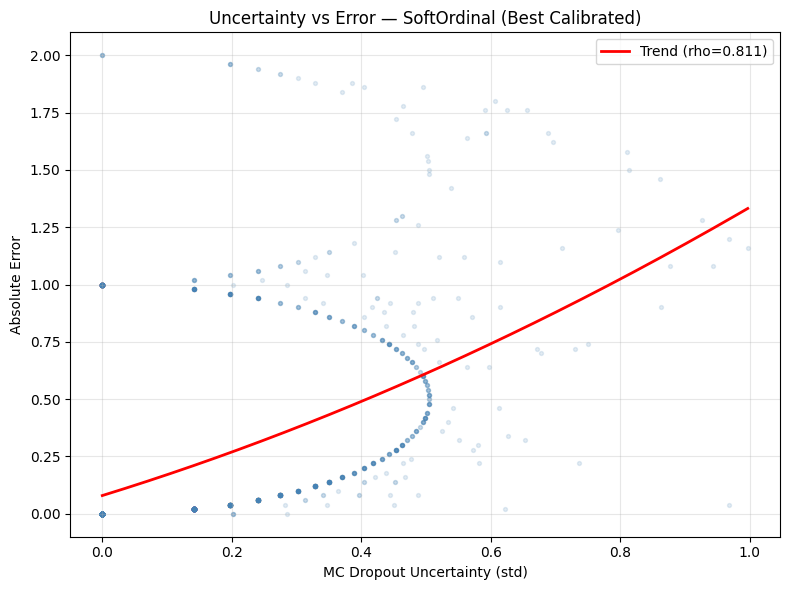

In [24]:
# Cell 5b — Calibration scatter for best-calibrated model
best_cal_model = max(all_calibration, key=lambda n: all_calibration[n]["global"])
res = all_results[best_cal_model]

unc_flat = res["uncertainties"].flatten()
err_flat = np.abs(res["predictions"] - res["targets"]).flatten()
global_corr = all_calibration[best_cal_model]["global"]

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(unc_flat, err_flat, alpha=0.15, s=8, color="steelblue")

finite_mask = np.isfinite(unc_flat) & np.isfinite(err_flat)
if finite_mask.sum() > 3:
    z = np.polyfit(unc_flat[finite_mask], err_flat[finite_mask], 2)
    p = np.poly1d(z)
    x_line = np.linspace(unc_flat[finite_mask].min(), unc_flat[finite_mask].max(), 200)
    ax.plot(
        x_line, p(x_line), "r-", linewidth=2, label=f"Trend (rho={global_corr:.3f})"
    )

ax.set_xlabel("MC Dropout Uncertainty (std)")
ax.set_ylabel("Absolute Error")
ax.set_title(f"Uncertainty vs Error — {best_cal_model} (Best Calibrated)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Section 6: Issue Scorecard

Summary of all diagnostics for before/after comparison.

In [25]:
# Cell 6.1 — Multi-model scorecard
print("=" * 90)
print("DIAGNOSTIC SCORECARD — MULTI-MODEL COMPARISON")
print("=" * 90)

# Issue #9 — Calibration
print(f"\n{'--- #9 Calibration ':-<90s}")
print(
    f"  {'Model':<15s} {'Global corr':>12s} {'Positive dims':>15s} {'Mean unc.':>12s}"
)
print(f"  {'-' * 56}")
for name in all_results:
    cal = all_calibration[name]
    print(
        f"  {name:<15s} {cal['global']:>+12.3f} "
        f"{cal['positive_count']:>13d}/10 {cal['mean_uncertainty']:>12.4f}"
    )
print(f"  Guidance: >0.1 useful, <0 dangerous (uncertainty misleads)")

# Issue #10 — Imbalance
print(f"\n{'--- #10 Imbalance ':-<90s}")
print(f"  Overall neutral %: {neutral_pct:.1f}%")
print(
    f"  Flagged dims (>10x imbalance): {sum(1 for r in imbalance_ratios if r > 10)}/10"
)
print(f"  Unlearnable dims: {unlearnable if unlearnable else 'None'}")
print(
    f"\n  {'Model':<15s} {'Recall -1':>10s} {'Recall +1':>10s} {'Mean minority':>15s}"
)
print(f"  {'-' * 52}")
for name in all_results:
    rd = all_recall_data[name]
    print(
        f"  {name:<15s} {rd['recall_minus1']:>10.1%} "
        f"{rd['recall_plus1']:>10.1%} {rd['mean_minority']:>15.1%}"
    )
print(f"  Guidance: Minority recall near 0% = model ignores rare classes")

# Ordinal quality
print(f"\n{'--- Ordinal Quality ':-<90s}")
print(f"  {'Model':<15s} {'QWK':>8s} {'Hedging %':>10s}")
print(f"  {'-' * 35}")
for name in all_results:
    qwk = all_results[name]["qwk_mean"]
    hedge = all_hedging[name].mean() * 100
    print(f"  {name:<15s} {qwk:>8.3f} {hedge:>9.1f}%")
print(f"  Guidance: High hedging % = neutral collapse; QWK near 0 = chance")

# Issue #12 — Overfitting
print(f"\n{'--- #12 Overfitting ':-<90s}")
print(
    f"  {'Model':<15s} {'Best epoch':>12s} {'Best val loss':>15s} {'Gap at best':>12s}"
)
print(f"  {'-' * 56}")
for name, result in trained_models.items():
    h = result["history"]
    be = result["best_epoch"]
    n_ep = len(h["train_loss"])
    bvl = result["best_val_loss"]
    gap = (
        h["val_loss"][be] - h["train_loss"][be]
        if len(h["train_loss"]) > be
        else float("nan")
    )
    print(f"  {name:<15s} {be + 1:>5d}/{n_ep:<5d} {bvl:>15.4f} {gap:>+12.4f}")
print(f"  Guidance: Ratio >10x high risk; gap >0.05 suggests overfitting")

# Issue #14 — Embedding (model-independent)
print(f"\n{'--- #14 Embedding ':-<90s}")
print(f"  Encoder: {CONFIG['encoder_model']}")
print(f"  Truncated entries: {pct_truncated:.1f}%")
print(
    f"  Guidance: Gap <0.1 = poor discrimination; >5% truncation = losing information"
)

# Winner summary
print(f"\n{'--- Winner Summary ':-<90s}")
best_qwk_model = max(all_results, key=lambda n: all_results[n]["qwk_mean"])
best_acc_model = max(all_results, key=lambda n: all_results[n]["accuracy_mean"])
best_mae_model = min(all_results, key=lambda n: all_results[n]["mae_mean"])
best_cal_model = max(all_calibration, key=lambda n: all_calibration[n]["global"])
print(
    f"  Best by QWK:         {best_qwk_model:<15s} "
    f"({all_results[best_qwk_model]['qwk_mean']:.3f})"
)
print(
    f"  Best by Accuracy:    {best_acc_model:<15s} "
    f"({all_results[best_acc_model]['accuracy_mean']:.2%})"
)
print(
    f"  Best by MAE:         {best_mae_model:<15s} "
    f"({all_results[best_mae_model]['mae_mean']:.4f})"
)
print(
    f"  Best by Calibration: {best_cal_model:<15s} "
    f"({all_calibration[best_cal_model]['global']:.3f})"
)

print(f"\n{'=' * 90}")

DIAGNOSTIC SCORECARD — MULTI-MODEL COMPARISON

--- #9 Calibration -----------------------------------------------------------------------
  Model            Global corr   Positive dims    Mean unc.
  --------------------------------------------------------
  CORAL                 +0.805            10/10       0.1119
  CORN                  +0.785            10/10       0.1096
  EMD                   +0.802            10/10       0.1109
  SoftOrdinal           +0.811            10/10       0.1180
  Guidance: >0.1 useful, <0 dangerous (uncertainty misleads)

--- #10 Imbalance ------------------------------------------------------------------------
  Overall neutral %: 74.8%
  Flagged dims (>10x imbalance): 5/10
  Unlearnable dims: None

  Model            Recall -1  Recall +1   Mean minority
  ----------------------------------------------------
  CORAL                 4.9%      49.6%           27.3%
  CORN                  5.7%      49.5%           27.6%
  EMD                   8.1%    

# Section 7: Experiment Logging

In [26]:
OBSERVATIONS = ""  # Leave empty; experiment-review skill will generate observations

from src.vif.experiment_logger import log_experiment_run

logged_paths = log_experiment_run(
    config=CONFIG,
    trained_models=trained_models,
    all_results=all_results,
    all_calibration=all_calibration,
    all_hedging=all_hedging,
    all_recall_data=all_recall_data,
    n_train=n_train,
    n_val=n_val,
    n_test=n_test,
    pct_truncated=pct_truncated,
    state_dim=state_encoder.state_dim,
    observations=OBSERVATIONS.strip(),
)
print(f"\nLogged {len(logged_paths)} experiments:")
for entry in logged_paths:
    tag = "UPDATED" if entry["status"] == "updated" else "CREATED"
    print(f"  [{tag}] {entry['path']}  ({entry['run_id']})")


Logged 4 experiments:
  [UPDATED] logs/experiments/runs/run_008_CORAL.yaml  (run_008)
  [UPDATED] logs/experiments/runs/run_008_CORN.yaml  (run_008)
  [UPDATED] logs/experiments/runs/run_008_EMD.yaml  (run_008)
  [UPDATED] logs/experiments/runs/run_008_SoftOrdinal.yaml  (run_008)
